In [127]:
%%shell
jupyter nbconvert --to html '/content/drive/MyDrive/PHD_DATA/PHD_Simran_95.ipynb'

[NbConvertApp] Converting notebook /content/drive/MyDrive/PHD_DATA/PHD_Simran_95.ipynb to html
[NbConvertApp] Writing 1304554 bytes to /content/drive/MyDrive/PHD_DATA/PHD_Simran_95.html


In [1]:
from google.colab import drive
drive.mount('/content/drive/')     #mounting the drive

Mounted at /content/drive/


In [2]:
import os
os.getcwd()

'/content'

Problem Statement

Your goal is to build an algorithm / model which is able to predict the market as accurately as possible (exciting!) You can choose the market of your choice from above to predict for or you can predict for multiple markets as well (The choice is yours depending on which one excites you most).
You also have freedom to choose the time period you predict forward for (you know your model best, so choose a time period that shows your models performance best) That means anything from next day predictions, to next month, to next year!

In [3]:
pip install statsmodels==0.12.1

     |████████████████████████████████| 9.5 MB 5.6 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [103]:
#importing required libraries
import pandas as pd
import numpy as np

import gc

## For visualization
import matplotlib.pyplot as plt    # Plotting library for Python
import seaborn as sns    #Seaborn is a library for making statistical graphics in Python

from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.arima.model import ARIMA

from datetime import date

from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

import pickle # Read and Save model - Serialization


from sklearn.metrics import mean_absolute_error,mean_squared_error

import warnings                    # Code to ignore warnings
warnings.filterwarnings("ignore")

Loading And Reading data

In [5]:
# Data is stored into the variables
NSE_train=pd.read_csv("/content/drive/MyDrive/job_assign/NSE Training Data - 1st Jan 2016 to 1st Jan 2022.csv",na_values=['unknown', '#', '$'])
NASDAQ_train=pd.read_csv("/content/drive/MyDrive/job_assign/NASDAQ Training Data - 1st Jan 2016 to 1st Jan 2022.csv",na_values=['unknown', '#', '$'])
BTC_train=pd.read_csv("/content/drive/MyDrive/job_assign/BTC-USD Training Data - 1st Jan 2016 to 1st Jan 2022.csv",na_values=['unknown', '#', '$'])
NSE_test=pd.read_csv("/content/drive/MyDrive/job_assign/NSE Out of Time Testing Data - 1st Jan 2022 to 4th Feb 2022.csv",na_values=['unknown', '#', '$'])
NASDAQ_test=pd.read_csv("/content/drive/MyDrive/job_assign/NASDAQ Out of Time Data - 1st Jan 2022 to 4th Feb 2022.csv",na_values=['unknown', '#', '$'])
BTC_test=pd.read_csv("/content/drive/MyDrive/job_assign/BTC-USD Out of Time Testing 1st Jan 2022 to 4th Feb 2022.csv",na_values=['unknown', '#', '$'])
# parse_dates= {"date" : ["year","month","day"]}

**Understanding Data**

First 5 rows of each loaded data set

In [7]:
# To get the top 5 records of train
NSE_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,7924.549805,7937.549805,7781.100098,7791.299805,7791.299805,134700.0
1,2016-01-05,7828.399902,7831.200195,7763.250000,7784.649902,7784.649902,145200.0
2,2016-01-06,7788.049805,7800.950195,7721.200195,7741.000000,7741.000000,147100.0
3,2016-01-07,7673.350098,7674.950195,7556.600098,7568.299805,7568.299805,188900.0
4,2016-01-08,7611.649902,7634.100098,7581.049805,7601.350098,7601.350098,157400.0


In [8]:
NASDAQ_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,4897.649902,4903.089844,4846.979980,4903.089844,4903.089844,2218420000
1,2016-01-05,4917.839844,4926.729980,4872.740234,4891.430176,4891.430176,1927380000
2,2016-01-06,4813.759766,4866.040039,4804.689941,4835.759766,4835.759766,2168620000
3,2016-01-07,4736.399902,4788.020020,4688.169922,4689.430176,4689.430176,2552590000
4,2016-01-08,4722.020020,4742.569824,4637.850098,4643.629883,4643.629883,2288750000


In [9]:
BTC_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
1,2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2,2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
3,2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
4,2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600


In [10]:
NSE_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,17387.150391,17646.650391,17383.300781,17625.699219,17625.699219,200500
1,2022-01-04,17681.400391,17827.599609,17593.550781,17805.250000,17805.250000,247400
2,2022-01-05,17820.099609,17944.699219,17748.849609,17925.250000,17925.250000,251500
3,2022-01-06,17768.500000,17797.949219,17655.550781,17745.900391,17745.900391,236500
4,2022-01-07,17797.599609,17905.000000,17704.550781,17812.699219,17812.699219,239300


In [11]:
NASDAQ_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-03,15732.500000,15832.799805,15644.089844,15832.799805,15832.799805,4412130000
1,2022-01-04,15852.139648,15852.139648,15512.410156,15622.719727,15622.719727,5109270000
2,2022-01-05,15547.160156,15586.299805,15095.179688,15100.169922,15100.169922,5011990000
3,2022-01-06,15024.150391,15198.450195,14914.870117,15080.860352,15080.860352,4774740000
4,2022-01-07,15095.719727,15171.019531,14877.629883,14935.900391,14935.900391,4229270000


In [12]:
BTC_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004
1,2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547
2,2022-01-03,47343.542969,47510.726563,45835.964844,46458.117188,46458.117188,33071628362
3,2022-01-04,46458.851563,47406.546875,45752.464844,45897.574219,45897.574219,42494677905
4,2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859


Shape of Loaded Data

In [13]:
print('Dimensions of NSE Train')
print(NSE_train.shape)

print('Dimensions of NASDAQ Train')
print(NASDAQ_train.shape)

print('Dimensions of BTC Train')
print(BTC_train.shape)

print('Dimensions of NSE Test')
print(NSE_test.shape)

print('Dimensions of NASDAQ Test')
print(NASDAQ_test.shape)

print('Dimensions of BTC Test')
print(BTC_test.shape)

Dimensions of NSE Train
(1481, 7)
Dimensions of NASDAQ Train
(1259, 7)
Dimensions of BTC Train
(2193, 7)
Dimensions of NSE Test
(23, 7)
Dimensions of NASDAQ Test
(23, 7)
Dimensions of BTC Test
(35, 7)


In [14]:
#function to get datatype, total Na's, levels all at once
def understand_data(data) :
    return(pd.DataFrame({"Datatype":NSE_train.dtypes,"No of NAs":NSE_train.isna().sum(),"No of Levels":NSE_train.apply(lambda x: x.nunique(),axis=0),"Levels":NSE_train.apply(lambda x: str(x.unique()),axis=0)}))

In [15]:
# Understanding train data
understand_data(NSE_train)

,Datatype,No of NAs,No of Levels,Levels
Date,object,0,1481,['2016-01-04' '2016-01-05' '2016-01-06' ... '2...
Open,float64,6,1466,[ 7924.549805 7828.399902 7788.049805 ... 17...
High,float64,6,1467,[ 7937.549805 7831.200195 7800.950195 ... 17...
Low,float64,6,1465,[ 7781.100098 7763.25 7721.200195 ... 17...
Close,float64,6,1459,[ 7791.299805 7784.649902 7741. ... 17...
Adj Close,float64,6,1459,[ 7791.299805 7784.649902 7741. ... 17...
Volume,float64,6,1266,[134700. 145200. 147100. ... 161700. 320800. 1...


In [16]:
#function to get datatype, total Na's, levels all at once
def understand_data(data) :
    return(pd.DataFrame({"Datatype":NSE_test.dtypes,"No of NAs":NSE_test.isna().sum(),"No of Levels":NSE_test.apply(lambda x: x.nunique(),axis=0),"Levels":NSE_test.apply(lambda x: str(x.unique()),axis=0)}))

In [17]:
# Understanding test data
understand_data(NSE_test)

,Datatype,No of NAs,No of Levels,Levels
Date,object,0,23,['2022-01-03' '2022-01-04' '2022-01-05' '2022-...
Open,float64,0,23,[17387.150391 17681.400391 17820.099609 17768....
High,float64,0,23,[17646.650391 17827.599609 17944.699219 17797....
Low,float64,0,23,[17383.300781 17593.550781 17748.849609 17655....
Close,float64,0,23,[17625.699219 17805.25 17925.25 17745....
Adj Close,float64,0,23,[17625.699219 17805.25 17925.25 17745....
Volume,int64,0,23,[200500 247400 251500 236500 239300 232400 220...


In [18]:
#function to get datatype, total Na's, levels all at once
def understand_data(data) :
    return(pd.DataFrame({"Datatype":NASDAQ_train.dtypes,"No of NAs":NASDAQ_train.isna().sum(),"No of Levels":NASDAQ_train.apply(lambda x: x.nunique(),axis=0),"Levels":NASDAQ_train.apply(lambda x: str(x.unique()),axis=0)}))

In [19]:
# Understanding test data
understand_data(NASDAQ_train)

,Datatype,No of NAs,No of Levels,Levels
Date,object,0,1259,['2016-01-04' '2016-01-05' '2016-01-06' ... '2...
Open,float64,0,1256,[ 4897.649902 4917.839844 4813.759766 ... 12...
High,float64,0,1258,[ 4903.089844 4926.72998 4866.040039 ... 12...
Low,float64,0,1259,[ 4846.97998 4872.740234 4804.689941 ... 12...
Close,float64,0,1254,[ 4903.089844 4891.430176 4835.759766 ... 12...
Adj Close,float64,0,1254,[ 4903.089844 4891.430176 4835.759766 ... 12...
Volume,int64,0,1250,[2218420000 1927380000 2168620000 ... 46807800...


In [20]:
#function to get datatype, total Na's, levels all at once
def understand_data(data) :
    return(pd.DataFrame({"Datatype":NASDAQ_test.dtypes,"No of NAs":NASDAQ_test.isna().sum(),"No of Levels":NASDAQ_test.apply(lambda x: x.nunique(),axis=0),"Levels":NASDAQ_test.apply(lambda x: str(x.unique()),axis=0)}))

In [21]:
# Understanding test data
understand_data(NASDAQ_test)

,Datatype,No of NAs,No of Levels,Levels
Date,object,0,23,['2022-01-03' '2022-01-04' '2022-01-05' '2022-...
Open,float64,0,23,[15732.5 15852.139648 15547.160156 15024....
High,float64,0,23,[15832.799805 15852.139648 15586.299805 15198....
Low,float64,0,23,[15644.089844 15512.410156 15095.179688 14914....
Close,float64,0,23,[15832.799805 15622.719727 15100.169922 15080....
Adj Close,float64,0,23,[15832.799805 15622.719727 15100.169922 15080....
Volume,int64,0,23,[4412130000 5109270000 5011990000 4774740000 4...


In [22]:
#function to get datatype, total Na's, levels all at once
def understand_data(data) :
    return(pd.DataFrame({"Datatype":BTC_train.dtypes,"No of NAs":BTC_train.isna().sum(),"No of Levels":BTC_train.apply(lambda x: x.nunique(),axis=0),"Levels":BTC_train.apply(lambda x: str(x.unique()),axis=0)}))

In [23]:
# Understanding test data
understand_data(BTC_train)

,Datatype,No of NAs,No of Levels,Levels
Date,object,0,2193,['2016-01-01' '2016-01-02' '2016-01-03' ... '2...
Open,float64,0,2192,[ 430.721008 434.622009 433.578003 ... 46...
High,float64,0,2192,[ 436.246002 436.062012 433.743011 ... 47...
Low,float64,0,2192,[ 427.515015 431.869995 424.705994 ... 46...
Close,float64,0,2191,[ 434.334015 433.437988 430.010986 ... 47...
Adj Close,float64,0,2191,[ 434.334015 433.437988 430.010986 ... 47...
Volume,int64,0,2193,[ 36278900 30096600 39633800 ... 26686...


In [24]:
#function to get datatype, total Na's, levels all at once
def understand_data(data) :
    return(pd.DataFrame({"Datatype":BTC_test.dtypes,"No of NAs":BTC_test.isna().sum(),"No of Levels":BTC_test.apply(lambda x: x.nunique(),axis=0),"Levels":BTC_test.apply(lambda x: str(x.unique()),axis=0)}))

In [25]:
# Understanding test data
understand_data(BTC_test)

,Datatype,No of NAs,No of Levels,Levels
Date,object,0,35,['2022-01-01' '2022-01-02' '2022-01-03' '2022-...
Open,float64,0,35,[46311.746094 47680.925781 47343.542969 46458....
High,float64,0,35,[47827.3125 47881.40625 47510.726563 47406....
Low,float64,0,35,[46288.484375 46856.9375 45835.964844 45752....
Close,float64,0,35,[47686.8125 47345.21875 46458.117188 45897....
Adj Close,float64,0,35,[47686.8125 47345.21875 46458.117188 45897....
Volume,int64,0,35,[24582667004 27951569547 33071628362 424946779...


**Data Preparation and Feature Engineering**


In [26]:
NSE_train['Date']=pd.to_datetime(NSE_train['Date'])

In [27]:
NSE_train['Month'] = pd.DatetimeIndex(NSE_train['Date']).month
NSE_train['Day']=pd.DatetimeIndex(NSE_train['Date']).day
NSE_train['Year']=pd.DatetimeIndex(NSE_train['Date']).year
NSE_train['Dayofweek']=pd.DatetimeIndex(NSE_train['Date']).dayofweek

In [28]:
NSE_test['Date']=pd.to_datetime(NSE_test['Date'])

In [29]:
NSE_test['Month'] = pd.DatetimeIndex(NSE_test['Date']).month
NSE_test['Day']=pd.DatetimeIndex(NSE_test['Date']).day
NSE_test['Year']=pd.DatetimeIndex(NSE_test['Date']).year
NSE_test['Dayofweek']=pd.DatetimeIndex(NSE_test['Date']).dayofweek

In [30]:
NASDAQ_train['Date']=pd.to_datetime(NASDAQ_train['Date'])

In [31]:
NASDAQ_train['Month'] = pd.DatetimeIndex(NASDAQ_train['Date']).month
NASDAQ_train['Day']=pd.DatetimeIndex(NASDAQ_train['Date']).day
NASDAQ_train['Year']=pd.DatetimeIndex(NASDAQ_train['Date']).year
NASDAQ_train['Dayofweek']=pd.DatetimeIndex(NASDAQ_train['Date']).dayofweek

In [33]:
NASDAQ_test['Date']=pd.to_datetime(NASDAQ_test['Date'])

In [34]:
NASDAQ_test['Month'] = pd.DatetimeIndex(NASDAQ_test['Date']).month
NASDAQ_test['Day']=pd.DatetimeIndex(NASDAQ_test['Date']).day
NASDAQ_test['Year']=pd.DatetimeIndex(NASDAQ_test['Date']).year
NASDAQ_test['Dayofweek']=pd.DatetimeIndex(NASDAQ_test['Date']).dayofweek

In [35]:
BTC_train['Date']=pd.to_datetime(BTC_train['Date'])

In [36]:
BTC_train['Month'] = pd.DatetimeIndex(BTC_train['Date']).month
BTC_train['Day']=pd.DatetimeIndex(BTC_train['Date']).day
BTC_train['Year']=pd.DatetimeIndex(BTC_train['Date']).year
BTC_train['Dayofweek']=pd.DatetimeIndex(BTC_train['Date']).dayofweek

In [37]:
BTC_test['Date']=pd.to_datetime(BTC_test['Date'])

In [38]:
BTC_test['Month'] = pd.DatetimeIndex(BTC_test['Date']).month
BTC_test['Day']=pd.DatetimeIndex(BTC_test['Date']).day
BTC_test['Year']=pd.DatetimeIndex(BTC_test['Date']).year
BTC_test['Dayofweek']=pd.DatetimeIndex(BTC_test['Date']).dayofweek

In [39]:
BTC_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Day,Year,Dayofweek
0,2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004,1,1,2022,5
1,2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547,1,2,2022,6
2,2022-01-03,47343.542969,47510.726563,45835.964844,46458.117188,46458.117188,33071628362,1,3,2022,0
3,2022-01-04,46458.851563,47406.546875,45752.464844,45897.574219,45897.574219,42494677905,1,4,2022,1
4,2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859,1,5,2022,2


In [42]:
# find if there is infinite value in dataframe
BTC_train.loc[BTC_train['Volume']==np.inf]

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Day,Year,Dayofweek


In [43]:
# find if there is infinite value in dataframe
NASDAQ_train.loc[NASDAQ_train['Volume']==np.inf]

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Day,Year,Dayofweek


In [44]:
# find if there is infinite value in dataframe
NSE_train.loc[NSE_train['Volume']==np.inf]

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Day,Year,Dayofweek


In [45]:
#negative value counts for the target column
NSE_train[NSE_train['Volume']<0].Volume.value_counts()

Series([], Name: Volume, dtype: int64)

In [46]:
NSE_train.duplicated(subset=['Date','Dayofweek', 'Open', 'High','Low', 'Close','Adj Close', 'Volume'], keep='first')

0       False
1       False
2       False
3       False
4       False
        ...  
1476    False
1477    False
1478    False
1479    False
1480    False
Length: 1481, dtype: bool

In [47]:
trainDupes = NSE_train[NSE_train.duplicated(subset=['Date','Dayofweek', 'Open', 'High','Low', 'Close','Adj Close', 'Volume'], keep='first')]
print(trainDupes.shape)

(0, 11)


In [48]:
#sorting via date
NSE_train.sort_values("Date", inplace=True, ascending=True)
NSE_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Day,Year,Dayofweek
0,2016-01-04,7924.549805,7937.549805,7781.100098,7791.299805,7791.299805,134700.0,1,4,2016,0
1,2016-01-05,7828.399902,7831.200195,7763.250000,7784.649902,7784.649902,145200.0,1,5,2016,1
2,2016-01-06,7788.049805,7800.950195,7721.200195,7741.000000,7741.000000,147100.0,1,6,2016,2
3,2016-01-07,7673.350098,7674.950195,7556.600098,7568.299805,7568.299805,188900.0,1,7,2016,3
4,2016-01-08,7611.649902,7634.100098,7581.049805,7601.350098,7601.350098,157400.0,1,8,2016,4


In [49]:
#Grouping and saving
series=NSE_train.groupby('Date')['Volume'].sum()

In [50]:
series

Date
2016-01-04    134700.0
2016-01-05    145200.0
2016-01-06    147100.0
2016-01-07    188900.0
2016-01-08    157400.0
                ...   
2021-12-27    144800.0
2021-12-28    176000.0
2021-12-29    161700.0
2021-12-30    320800.0
2021-12-31    167000.0
Name: Volume, Length: 1481, dtype: float64

In [51]:
# Checking if there are any missing dates in train and test data.
print(min(NSE_train.Date.unique()))
print(max(NSE_test.Date.unique()))

print(NSE_train.Date.nunique())

2016-01-04T00:00:00.000000000
2022-02-03T00:00:00.000000000
1481


In [52]:
# Let us calculate the number of days between the start and end date
d0 = date(2016, 1, 4)
d1 = date(2021, 12, 31)
delta = d1 - d0
print(delta.days)

2188


In [ ]:
##As we can see 707 days are missing in the train data. Let us see what those days are.

In [53]:
pd.date_range(start='2016-01-04', end='2021-12-31').shape
#Returns the range of equally spaced time points

(2189,)

In [54]:
#for missing range /days
pd.date_range(start='2016-01-04', end='2021-12-31').difference(NSE_train.Date)
# The missing dates are below:

DatetimeIndex(['2016-01-09', '2016-01-10', '2016-01-16', '2016-01-17',
               '2016-01-23', '2016-01-24', '2016-01-26', '2016-01-30',
               '2016-01-31', '2016-02-06',
               ...
               '2021-11-27', '2021-11-28', '2021-12-04', '2021-12-05',
               '2021-12-11', '2021-12-12', '2021-12-18', '2021-12-19',
               '2021-12-25', '2021-12-26'],
              dtype='datetime64[ns]', length=708, freq=None)

In [55]:
idx=pd.date_range(start='2016-01-04', end='2021-12-31')
series_new= series.reindex(idx, fill_value=0) #and replacing the missing Volumes with 0
print(series_new)

2016-01-04    134700.0
2016-01-05    145200.0
2016-01-06    147100.0
2016-01-07    188900.0
2016-01-08    157400.0
                ...   
2021-12-27    144800.0
2021-12-28    176000.0
2021-12-29    161700.0
2021-12-30    320800.0
2021-12-31    167000.0
Freq: D, Name: Volume, Length: 2189, dtype: float64


**Time Series Decomposition**

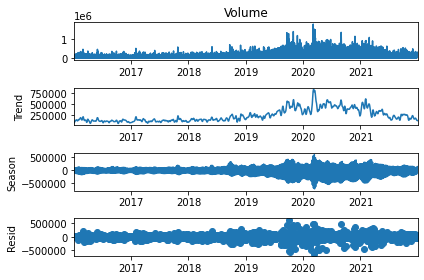

In [56]:
res = STL(series_new).fit()    #decomposing trend, residuality
res.plot()
plt.show()

In [57]:
#data is stationary as there is no trend

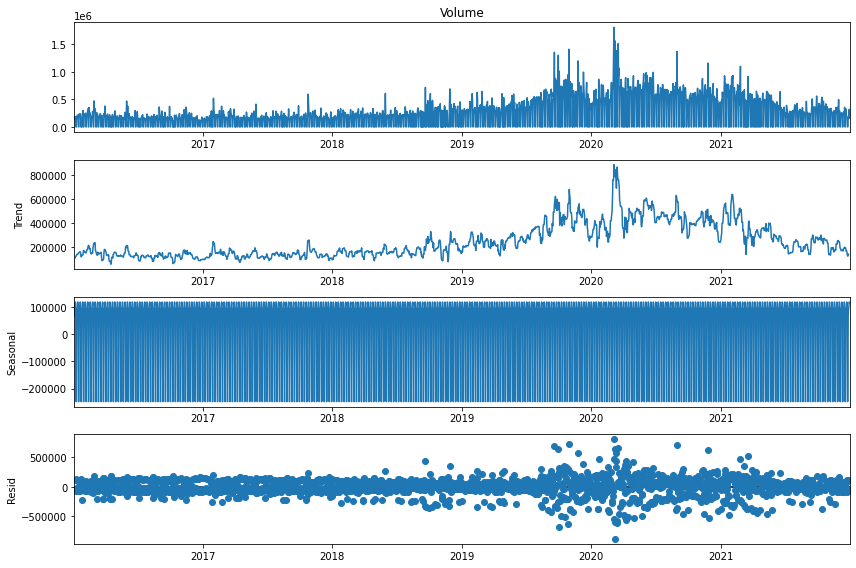

In [58]:
## Additive model
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 12, 8
decomposition = sm.tsa.seasonal_decompose(series_new, model='additive')
fig = decomposition.plot()
plt.show()

**Stationarity test**

In [59]:
#statistical test to test the stationarity of time series data
# adfuller is used to test for a unit root in a univariate process in the presence of serial correlation

#H0 - Unit root is present in time series. Hence, data is non-stationary.
#H1 = The time series is stationary.
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [60]:
adf_test(series_new)

Results of Dickey-Fuller Test:
Test Statistic                   -2.920266
p-value                           0.043042
#Lags Used                       22.000000
Number of Observations Used    2166.000000
Critical Value (1%)              -3.433373
Critical Value (5%)              -2.862875
Critical Value (10%)             -2.567481
dtype: float64


In [61]:
#At 95% confidence level
#alpha =0.05
#if p value< alpha :Reject H0
#if p value > alpha : Fail to reject H0
# since p-value < alpha(0.05 at 95% confidence level) we reject H0
# Hence the data is stationary

In [116]:
# # Create Train and Test for ARIMA Model
train_arima = series_new[1:1400]
test_arima = series_new.values[1400:1490]

In [117]:
# #ARIMA Model
model = ARIMA(series_new, order=(1,0,1))
data= series_new
 #fit model
model_fit=model.fit()
 #make prediction
yhat=model_fit.predict(len(data), len(data))
print(yhat)

2022-01-01    187878.884081
Freq: D, dtype: float64


In [118]:
len(series_new)

2189

In [119]:
trainModel = ARIMA(train_arima, order=(1,0,1))
trainModel_fit = trainModel.fit()
yhatTr = trainModel_fit.predict(len(train_arima), len(train_arima))
yhatTr

2019-11-04    144568.803641
Freq: D, dtype: float64

In [120]:
testModel = ARIMA(test_arima, order=(1,0,1))
testModel_fit = testModel.fit()
yhatTest = testModel_fit.predict(len(test_arima), len(test_arima))
yhatTest

array([138259.98207684])

In [123]:
#RMSE
train4RMSE = train_arima[0:1400]
print(train_arima.head())
print(train4RMSE.head())
print(train_arima.shape)
print(train4RMSE.shape)

2016-01-05    145200.0
2016-01-06    147100.0
2016-01-07    188900.0
2016-01-08    157400.0
2016-01-09         0.0
Freq: D, Name: Volume, dtype: float64
2016-01-05    145200.0
2016-01-06    147100.0
2016-01-07    188900.0
2016-01-08    157400.0
2016-01-09         0.0
Freq: D, Name: Volume, dtype: float64
(1399,)
(1399,)


In [124]:
trainModel4RMSE = ARIMA(train4RMSE, order=(0,0,1))
trainModel_fit4RMSE = trainModel.fit()
yhatTr4RMSE = trainModel_fit4RMSE.predict(0, len(train4RMSE))
yhatTr4RMSE.shape

(1400,)

In [125]:
print(train4RMSE.shape)
print(yhatTr4RMSE.shape)
print(train4RMSE.head())
print(yhatTr4RMSE.head())
print(train4RMSE.tail())
print(yhatTr4RMSE.tail())

(1399,)
(1400,)
2016-01-05    145200.0
2016-01-06    147100.0
2016-01-07    188900.0
2016-01-08    157400.0
2016-01-09         0.0
Freq: D, Name: Volume, dtype: float64
2016-01-05    178967.905647
2016-01-06    166192.878958
2016-01-07    169875.051731
2016-01-08    186648.999270
2016-01-09    166696.114165
Freq: D, Name: predicted_mean, dtype: float64
2019-10-30     725200.0
2019-10-31    1414800.0
2019-11-01     855300.0
2019-11-02          0.0
2019-11-03          0.0
Freq: D, Name: Volume, dtype: float64
2019-10-31    283824.874307
2019-11-01    681449.277107
2019-11-02    289855.202117
2019-11-03     59718.464918
2019-11-04    144568.803641
Freq: D, Name: predicted_mean, dtype: float64


In [ ]:
#merging them into one variable that it becomes easier for the algorithm to understand the pattern and creates less branches 

In [68]:
#merging train data of all
merge_first = pd.merge(NSE_train, NASDAQ_train, how='left', on=['Date',	'Open',	'High',	'Low',	'Close','Volume',	'Adj Close','Month',	'Day',	'Year',	'Dayofweek'])
merge_first.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Day,Year,Dayofweek
0,2016-01-04,7924.549805,7937.549805,7781.100098,7791.299805,7791.299805,134700.0,1,4,2016,0
1,2016-01-05,7828.399902,7831.200195,7763.250000,7784.649902,7784.649902,145200.0,1,5,2016,1
2,2016-01-06,7788.049805,7800.950195,7721.200195,7741.000000,7741.000000,147100.0,1,6,2016,2
3,2016-01-07,7673.350098,7674.950195,7556.600098,7568.299805,7568.299805,188900.0,1,7,2016,3
4,2016-01-08,7611.649902,7634.100098,7581.049805,7601.350098,7601.350098,157400.0,1,8,2016,4


In [69]:
merge_train=pd.merge(BTC_train, merge_first, how='left', on=['Date',	'Open',	'High',	'Low',	'Close','Volume',	'Adj Close','Month',	'Day',	'Year',	'Dayofweek'])
merge_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Day,Year,Dayofweek
0,2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900,1,1,2016,4
1,2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600,1,2,2016,5
2,2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800,1,3,2016,6
3,2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500,1,4,2016,0
4,2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600,1,5,2016,1


In [70]:
#merging test data of all
merge_second = pd.merge(NSE_test, NASDAQ_test, how='left', on=['Date',	'Open',	'High',	'Low',	'Close','Volume',	'Adj Close','Month',	'Day',	'Year',	'Dayofweek'])
merge_second.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Day,Year,Dayofweek
0,2022-01-03,17387.150391,17646.650391,17383.300781,17625.699219,17625.699219,200500,1,3,2022,0
1,2022-01-04,17681.400391,17827.599609,17593.550781,17805.250000,17805.250000,247400,1,4,2022,1
2,2022-01-05,17820.099609,17944.699219,17748.849609,17925.250000,17925.250000,251500,1,5,2022,2
3,2022-01-06,17768.500000,17797.949219,17655.550781,17745.900391,17745.900391,236500,1,6,2022,3
4,2022-01-07,17797.599609,17905.000000,17704.550781,17812.699219,17812.699219,239300,1,7,2022,4


In [71]:
#merging train data of all
merge_test = pd.merge(BTC_test, merge_second, how='left', on=['Date',	'Open',	'High',	'Low',	'Close','Volume',	'Adj Close','Month',	'Day',	'Year',	'Dayofweek'])
merge_test.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Month,Day,Year,Dayofweek
0,2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004,1,1,2022,5
1,2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547,1,2,2022,6
2,2022-01-03,47343.542969,47510.726563,45835.964844,46458.117188,46458.117188,33071628362,1,3,2022,0
3,2022-01-04,46458.851563,47406.546875,45752.464844,45897.574219,45897.574219,42494677905,1,4,2022,1
4,2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859,1,5,2022,2


**Preparing Data For the Model**

Train Test Split

In [73]:
# Preparing the dataset:
X_train_new = merge_train[['Open',	'High',	'Low','Close','Volume',	'Adj Close','Month','Year',	'Dayofweek']].columns.values
X_test_new = merge_test[['Open',	'High',	'Low','Close','Volume',	'Adj Close','Month','Year',	'Dayofweek']].columns.values
target= ['Volume']

In [74]:
print(X_train_new)
print(X_test_new)

['Open' 'High' 'Low' 'Close' 'Volume' 'Adj Close' 'Month' 'Year'
 'Dayofweek']
['Open' 'High' 'Low' 'Close' 'Volume' 'Adj Close' 'Month' 'Year'
 'Dayofweek']


In [75]:
# As this is a time series data, split shouldn't be performed randomly, instead should be performed sequentially (by retaining order)

In [77]:
# Splitting and training
train_rows = merge_train.loc[(merge_train['Date'] >= pd.to_datetime('2021-03-01')) & (merge_train['Date'] <= pd.to_datetime('2021-05-31')), :].index
valid_rows = merge_train.loc[(merge_train['Date'] >= pd.to_datetime('2021-06-01')), :].index
#checking with 2 months of data

In [78]:
X_train = merge_train.loc[train_rows, X_train_new]
y_train = merge_train.loc[train_rows, target]
X_val = merge_train.loc[valid_rows, X_train_new]
y_val = merge_train.loc[valid_rows, target]
test_new = merge_test.loc[:, X_test_new]

In [79]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, test_new.shape)

(92, 9) (92, 1) (215, 9) (215, 1) (35, 9)


In [80]:
print(X_train.columns)
print(y_train.columns)
print(X_val.columns)
print(y_val.columns)
print(test_new.columns)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Month', 'Year',
       'Dayofweek'],
      dtype='object')
Index(['Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Month', 'Year',
       'Dayofweek'],
      dtype='object')
Index(['Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close', 'Month', 'Year',
       'Dayofweek'],
      dtype='object')


In [81]:
X_train.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Volume         int64
Adj Close    float64
Month          int64
Year           int64
Dayofweek      int64
dtype: object

Data Type Conversions

In [82]:
# Let's also identify the numeric and categorical columns.
numeric_cols = ["Open", "High","Low","Close","Adj Close"]
cat_cols = ["Year", "Month", 'Dayofweek']

In [83]:
# Convert all the categorical columns to appropriate data type for train data
X_train[cat_cols] = X_train[cat_cols].astype('category')
X_val[cat_cols] = X_val[cat_cols].astype('category')
test_new[cat_cols] = test_new[cat_cols].astype('category')

In [84]:
X_train.dtypes

Open          float64
High          float64
Low           float64
Close         float64
Volume          int64
Adj Close     float64
Month        category
Year         category
Dayofweek    category
dtype: object

Imputing the NA's

In [85]:
# how many missing values exist or better still what is the % of missing values in the dataset?
def percent_missing(df):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print("The pharmaceutical dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

print(percent_missing(X_train))
print(percent_missing(X_val))
print(percent_missing(test_new))

The pharmaceutical dataset contains 0.0 % missing values.
None
The pharmaceutical dataset contains 0.0 % missing values.
None
The pharmaceutical dataset contains 0.0 % missing values.
None


In [86]:
# Check if there is any null value in the dataframes
print("\n==train==")
print(X_train.isnull().sum())
print("\n==val==")
print(X_val.isnull().sum())
print("\n==test==")
print(test_new.isnull().sum())


==train==
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
Month        0
Year         0
Dayofweek    0
dtype: int64

==val==
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
Month        0
Year         0
Dayofweek    0
dtype: int64

==test==
Open         0
High         0
Low          0
Close        0
Volume       0
Adj Close    0
Month        0
Year         0
Dayofweek    0
dtype: int64


In [ ]:
#Hence, there are no null values

In [87]:
numeric_cols = X_train.select_dtypes(include = ['int', 'float']).columns
numeric_cols

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [88]:
#Running DataFrameMapper on Train Data
mapper = DataFrameMapper(
  [([numeric], StandardScaler()) for numeric in numeric_cols] +
  [([categorical], OneHotEncoder(handle_unknown='ignore')) for categorical in cat_cols]       # encoding the categorical variables
, df_out=True)

print((mapper))

#Data Scaling and Data Encoding

DataFrameMapper(df_out=True,
                features=[(['Open'], StandardScaler()),
                          (['High'], StandardScaler()),
                          (['Low'], StandardScaler()),
                          (['Close'], StandardScaler()),
                          (['Volume'], StandardScaler()),
                          (['Adj Close'], StandardScaler()),
                          (['Year'], OneHotEncoder(handle_unknown='ignore')),
                          (['Month'], OneHotEncoder(handle_unknown='ignore')),
                          (['Dayofweek'],
                           OneHotEncoder(handle_unknown='ignore'))])


In [89]:
# Fitting on train data
mapper.fit(X_train)

DataFrameMapper(df_out=True,
                features=[(['Open'], StandardScaler()),
                          (['High'], StandardScaler()),
                          (['Low'], StandardScaler()),
                          (['Close'], StandardScaler()),
                          (['Volume'], StandardScaler()),
                          (['Adj Close'], StandardScaler()),
                          (['Year'], OneHotEncoder(handle_unknown='ignore')),
                          (['Month'], OneHotEncoder(handle_unknown='ignore')),
                          (['Dayofweek'],
                           OneHotEncoder(handle_unknown='ignore'))])

In [90]:
# Transforming on train, validation and test data
X_train = mapper.transform(X_train)
X_val = mapper.transform(X_val)
test_new = mapper.transform(test_new)

In [91]:
# Checking the number of columns in train, val and test after one hot encoding
print(X_train.shape[1])
print(X_val.shape[1])
print(test_new.shape[1])

17
17
17


**Model Building**

In [92]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def ErrorMetrics(train_y,train_pred,val_y,val_pred):
    print("-----Train Error------")
    print("SSE:", mean_squared_error(train_y, train_pred))
    print("RMSE:", np.sqrt(mean_squared_error(train_y, train_pred)))
  

    print("-----Validation Error------")
    print("SSE:", mean_squared_error(val_y, val_pred))
    print("RMSE:", np.sqrt(mean_squared_error(val_y, val_pred)))

In [93]:
# To Save and reload data/model using pickle and shutil

# To create a folder in colab (if it doesn't exist already) that will take backup data/models
PATH = '/content/drive/MyDrive/PHD_DATA/pickle_file'
#if os.path.exists(PATH):
#  shutil.rmtree(PATH)
#os.mkdir(PATH)
if not(os.path.exists(PATH)):
  os.mkdir(PATH)

# To create backup and storing backedup files in the created folder path using pickle
def create_backupfiles(filename, dfin):
  outfile = open(filename, 'wb')
  pkl.dump(dfin, outfile)
  outfile.close()

# To reload backedup data
def reload_backupfiles(filename):
  infile = open(filename, 'rb')
  dfout = pkl.load(infile)
  infile.close()
  return(dfout)

In [94]:
# DecisionTree Model
dt1 = DecisionTreeRegressor()

# Fit model on train data
%time dt1.fit(X_train, y_train)

#Fitting the regressor to the training set and make predictions on the test set using .predict() method

# Evaluate the model on train and val
ErrorMetrics(y_train, dt1.predict(X_train), y_val, dt1.predict(X_val))

CPU times: user 5.09 ms, sys: 1.98 ms, total: 7.07 ms
Wall time: 16.3 ms
-----Train Error------
SSE: 0.0
RMSE: 0.0
-----Validation Error------
SSE: 1.574067670385527e+19
RMSE: 3967452167.80937


In [ ]:
# Train and validation error go hand in hand, but the error is high

In [100]:
# Random Forest Model
rf1 = RandomForestRegressor(random_state = 1)

# Fit model on train data
%time rf1.fit(X_train, y_train)

# Generating predictions on train and val data
train_pred = rf1.predict(X_train)
val_pred = rf1.predict(X_val)

# Evaluate the model on train and val
ErrorMetrics(y_train, train_pred, y_val, val_pred)

CPU times: user 157 ms, sys: 1.73 ms, total: 158 ms
Wall time: 160 ms
-----Train Error------
SSE: 1.4934051868720512e+18
RMSE: 1222049584.4572148
-----Validation Error------
SSE: 3.437091434372136e+19
RMSE: 5862671263.487435


In [104]:
# Random Forest Model with Grid Search
rf_grid = RandomForestRegressor(random_state = 1)
param_grid = {"n_estimators" : np.arange(50, 150, 20),
             "max_depth" : [2, 3, 4, 5, None],
             "min_samples_leaf" : [2, 5, 7, 9, None]}

rf2 = GridSearchCV(rf_grid, param_grid, cv = 5)

# Fit model on train data
%time rf2.fit(X_train, y_train)
print(rf2.best_score_, rf2.best_params_)

# Generating predictions on train and val data
train_pred = rf2.predict(X_train)
val_pred = rf2.predict(X_val)

# Evaluate the model on train and val
ErrorMetrics(y_train, train_pred, y_val, val_pred)

CPU times: user 1min 8s, sys: 301 ms, total: 1min 8s
Wall time: 1min 8s
0.9571137247257162 {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 90}
-----Train Error------
SSE: 6.296299485709909e+18
RMSE: 2509242811.230095
-----Validation Error------
SSE: 4.096117454204429e+19
RMSE: 6400091760.4394


Predictions on Test

In [95]:
#Generating and Uploading test predictions

In [96]:
dt1.predict(test_new)

array([3.16460809e+10, 3.16460809e+10, 3.43635647e+10, 4.31374594e+10,
       3.90098476e+10, 3.16460809e+10, 8.66686673e+10, 3.16460809e+10,
       3.16460809e+10, 3.16460809e+10, 3.16460809e+10, 3.43635647e+10,
       4.66552085e+10, 3.16460809e+10, 3.16460809e+10, 3.16460809e+10,
       3.16460809e+10, 3.16460809e+10, 3.16460809e+10, 3.16460809e+10,
       4.52310133e+10, 3.90098476e+10, 3.16460809e+10, 4.32109687e+10,
       3.16460809e+10, 3.16460809e+10, 3.16460809e+10, 3.16460809e+10,
       3.16460809e+10, 3.16460809e+10, 3.16460809e+10, 3.16460809e+10,
       3.16460809e+10, 3.16460809e+10, 3.16460809e+10])